Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [53]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt
from scipy import stats
from scipy.interpolate import interp1d

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [54]:
# Daten laden Gyroscope_Jump
file_name = '/csv_data/Gyroscope_Jump.csv' 
try:
    gyr_jp = pd.read_csv(os.getcwd() + file_name, delimiter=',')
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()


In [55]:
# Daten laden Gyroscope_Squat
file_name = '/csv_data/Gyroscope_Squat.csv' 
try:
    gyr_sq = pd.read_csv(os.getcwd() + file_name, delimiter=',')
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()


In [56]:
# Daten laden Linear_Acceleration_Jump
file_name = '/csv_data/Linear_Acceleration_Jump.csv' 
try:
    acc_jp = pd.read_csv(os.getcwd() + file_name, delimiter=',')
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()


In [57]:
# Daten laden Linear_Acceleration_Squat
file_name = '/csv_data/Linear_Acceleration_Squat.csv'
try:
    acc_sq = pd.read_csv(os.getcwd() + file_name, delimiter=',')
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()


Plots für das Springen

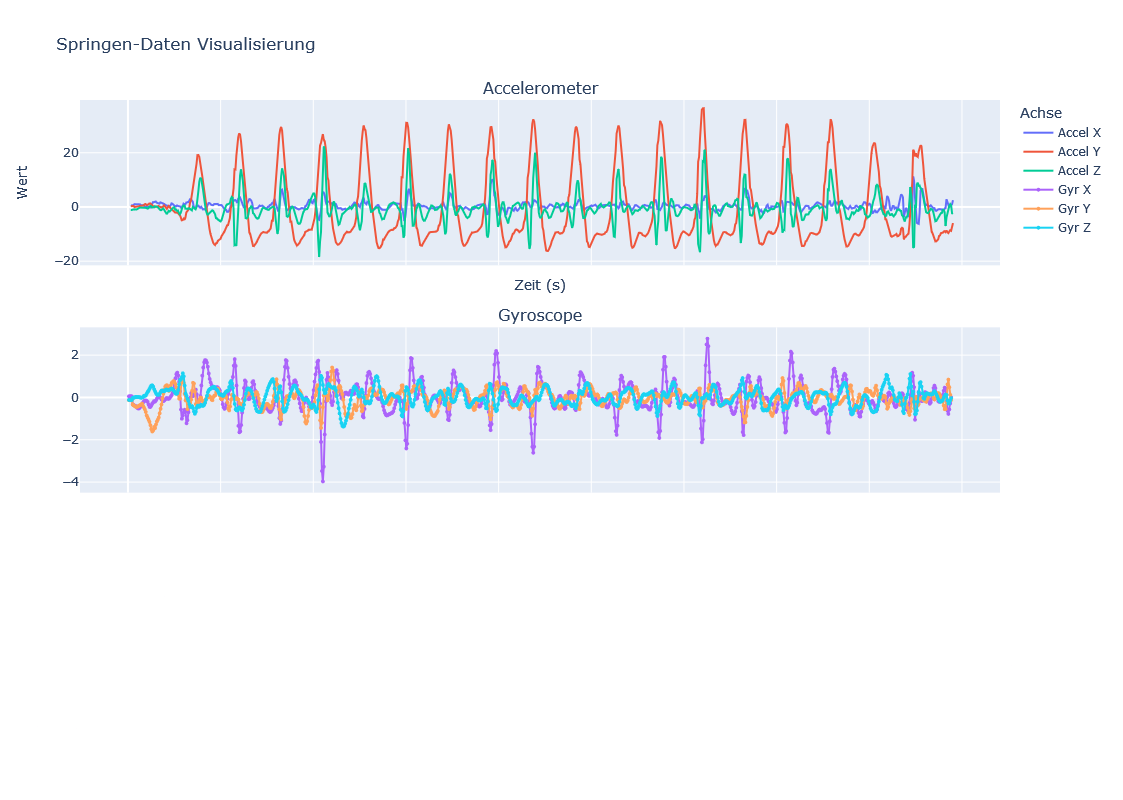

In [58]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
# Subplot 1: Accelerometer-Daten
fig.add_trace(go.Scatter(x=acc_jp['Time (s)'], y=acc_jp['Linear Acceleration x (m/s^2)'], name='Accel X'))
fig.add_trace(go.Scatter(x=acc_jp['Time (s)'], y=acc_jp['Linear Acceleration y (m/s^2)'], name='Accel Y'))
fig.add_trace(go.Scatter(x=acc_jp['Time (s)'], y=acc_jp['Linear Acceleration z (m/s^2)'], name='Accel Z'))

# Subplot 2: Gyroscope-Daten
fig.add_trace(go.Scatter(x=gyr_jp['Time (s)'], y=gyr_jp['Gyroscope x (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr X'), row=2, col=1)
fig.add_trace(go.Scatter(x=gyr_jp['Time (s)'], y=gyr_jp['Gyroscope y (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr Y'), row=2, col=1)
fig.add_trace(go.Scatter(x=gyr_jp['Time (s)'], y=gyr_jp['Gyroscope z (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr Z'), row=2, col=1)

# Aktualisiere Layout und Labels
fig.update_layout(title='Springen-Daten Visualisierung',
                  xaxis_title='Zeit (s)',
                  yaxis_title='Wert',
                  legend_title='Achse',
                  height=800, width=1000)
fig.show()


Plots für die Kniebeugen

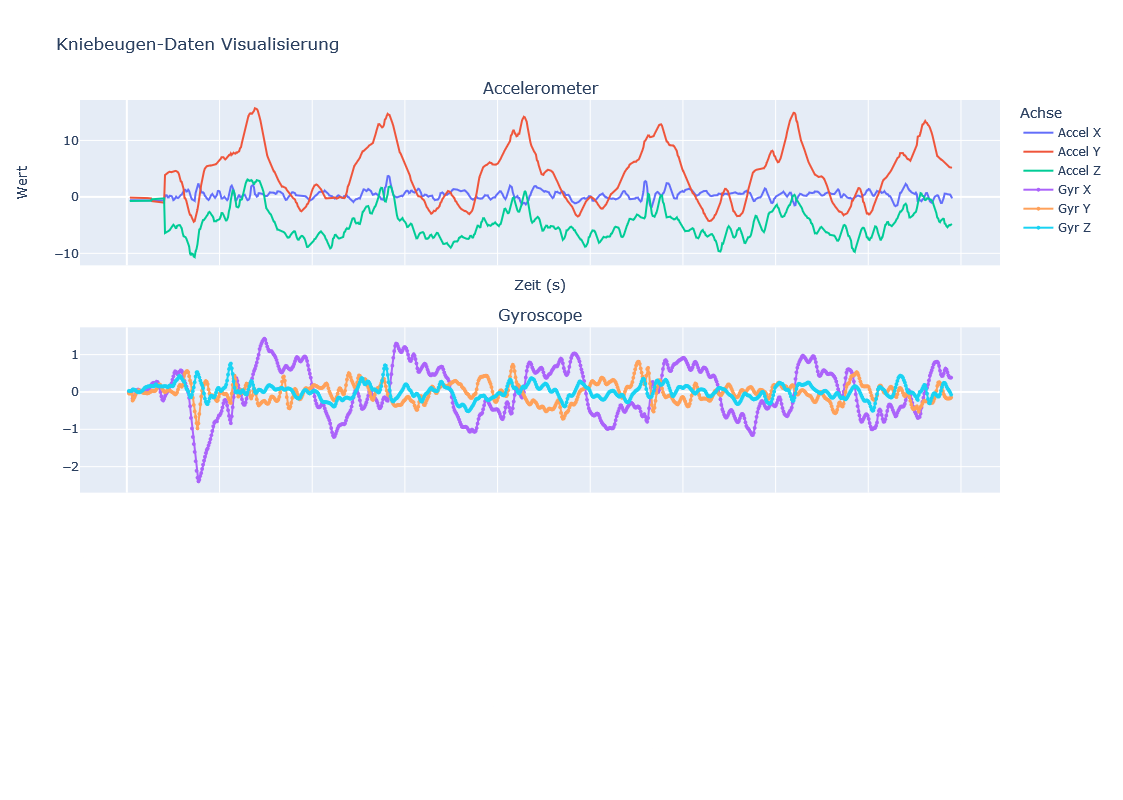

In [59]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
# Subplot 1: Accelerometer-Daten
fig.add_trace(go.Scatter(x=acc_sq['Time (s)'], y=acc_sq['Linear Acceleration x (m/s^2)'], name='Accel X'))
fig.add_trace(go.Scatter(x=acc_sq['Time (s)'], y=acc_sq['Linear Acceleration y (m/s^2)'], name='Accel Y'))
fig.add_trace(go.Scatter(x=acc_sq['Time (s)'], y=acc_sq['Linear Acceleration z (m/s^2)'], name='Accel Z'))

# Subplot 2: Gyroscope-Daten
fig.add_trace(go.Scatter(x=gyr_sq['Time (s)'], y=gyr_sq['Gyroscope x (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr X'), row=2, col=1)
fig.add_trace(go.Scatter(x=gyr_sq['Time (s)'], y=gyr_sq['Gyroscope y (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr Y'), row=2, col=1)
fig.add_trace(go.Scatter(x=gyr_sq['Time (s)'], y=gyr_sq['Gyroscope z (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr Z'), row=2, col=1)

# Aktualisiere Layout und Labels
fig.update_layout(title='Kniebeugen-Daten Visualisierung',
                  xaxis_title='Zeit (s)',
                  yaxis_title='Wert',
                  legend_title='Achse',
                  height=800, width=1000)
fig.show()